# Содержание
#### [**Задание**](#01)
1. [**EDA (Exploratory Data Analysis)**](#02)
    - [**Получение общего представления о данных**](#02.1)
        - [**Базовая информация (Пропуски, дубликаты, datatypes)**](#02.1.1)
    - [**Получение более подробной информации о данных**](#02.2)
        - [**Топ-15 банков по числу отзывов**](#02.2.1)
        - [**Банк с самым высоким средним рейтингом из топ-15**](#02.2.2)
        - [**Вывод об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов**](#02.2.3)
    - [**Дополнительный EDA**](#02.3)
2. [**Построение модели бинарной текстовой классификации**](#03)
    - [**Подготовка данных**](#03.1)
    - [**С применением Logistic Regression**](#03.2)
    - [**На PyTorch с применением RNN LSTM**](#03.3)

# Задание <a class="anchor" id="01"></a>

### Анализ отзывов на банки

В данных представлены отзывы, структура:
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

-----

#### Часть 1: Предварительный анализ данных
Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

-----

#### Часть 2: Построение модели бинарной текстовой классификации

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

# Решение

## Импортирование необходимых модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

## 1. EDA (Exploratory Data Analysis) <a class="anchor" id="02"></a>

### 1.1 Получение общего представления о данных

In [8]:
data = pd.read_csv("../../src/data/parsed_reviews3.csv")

#### 1.1.1 Базовая информация (Пропуски, дубликаты, datatypes)

In [9]:
data

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36
...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [11]:
data["body"].head(1)

0    &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...
Name: body, dtype: object

In [12]:
data.isna().sum()

body         0
title        0
rating       0
bank_name    0
date         0
dtype: int64

**Исходя из полученной информации можно сделать вывод, что пропусков в данных нет, однако, я заметил, что столбец *`date`* имеет некорректный datatype для отображения даты (в виде строки), чтобы избежать ряда проблем (например, при работе с временными интервалами) нужно его преобразовать в тип данных `datetime`**

- **Также в столбце `body`, который представляет собой сами отзывы, имеется большое количество различных `html-тегов` и других лишних символов. Для построения модели бинарной классификации нужно провести лемматизацию текста, а также выполнить фильтрацию отзывов с использованием регулярных выражений для извлечения ненужных тегов и символов :)**

- **Преобразуем столбец `date` в нужный тип данных:**

In [13]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

body                 object
title                object
rating                int64
bank_name            object
date         datetime64[ns]
dtype: object

- **Проверим ***наличие дубликатов*** в данных**

In [14]:
data.duplicated().sum()

62

- **Выведем их**

In [15]:
data[data.duplicated(keep=False)]

,body,title,rating,bank_name,date
898,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
996,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1610,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
...,...,...,...,...,...
77358,"&lt;p&gt;Добрый вечер, сегодня я хотел бы расс...",Моё мнение о банке,5,Тинькофф Банк,2022-10-20 18:33:45
85894,Здравствуйте! Хочу поблагодарить сотрудника Хо...,Оформление онлайн потребительского кредита,5,Хоум Кредит Банк,2022-09-25 18:48:43
85895,Здравствуйте! Хочу поблагодарить сотрудника Хо...,Оформление онлайн потребительского кредита,5,Хоум Кредит Банк,2022-09-25 18:48:43
90270,Давно являюсь клиентом Совкомбанка всегда отзы...,Один из лучших банков,5,Совкомбанк,2022-09-10 14:26:29


**Необходимо избавиться от дубликатов, поскольку это может привести к переобучению модели, а также к искажению статистических показателей**

- **Отбросим дубликаты**

In [16]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### 1.2 Получение более подробной информации о данных <a class="anchor" id="02.2"></a>

А именно:

- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

#### `1.2.1` ТОП-15 банков по числу отзывов <a class="anchor" id="02.2.1"></a>

In [17]:
reviews_per_bank = data.groupby(['bank_name']).agg({'bank_name': ['count']})
reviews_per_bank.columns = ['count']
reviews_per_bank = reviews_per_bank.sort_values(by='count', ascending=False).head(15)

reviews_per_bank = reviews_per_bank.reset_index()

reviews_per_bank.index += 1

reviews_per_bank

,bank_name,count
1,Тинькофф Банк,44852
2,Хоум Кредит Банк,9301
3,Совкомбанк,6100
4,ВТБ,3814
5,СберБанк,3487
6,Альфа-Банк,3368
7,Россельхозбанк,3062
8,Банк Открытие,1894
9,МТС Банк,1542
10,Модульбанк,1452


**Визуализируем**

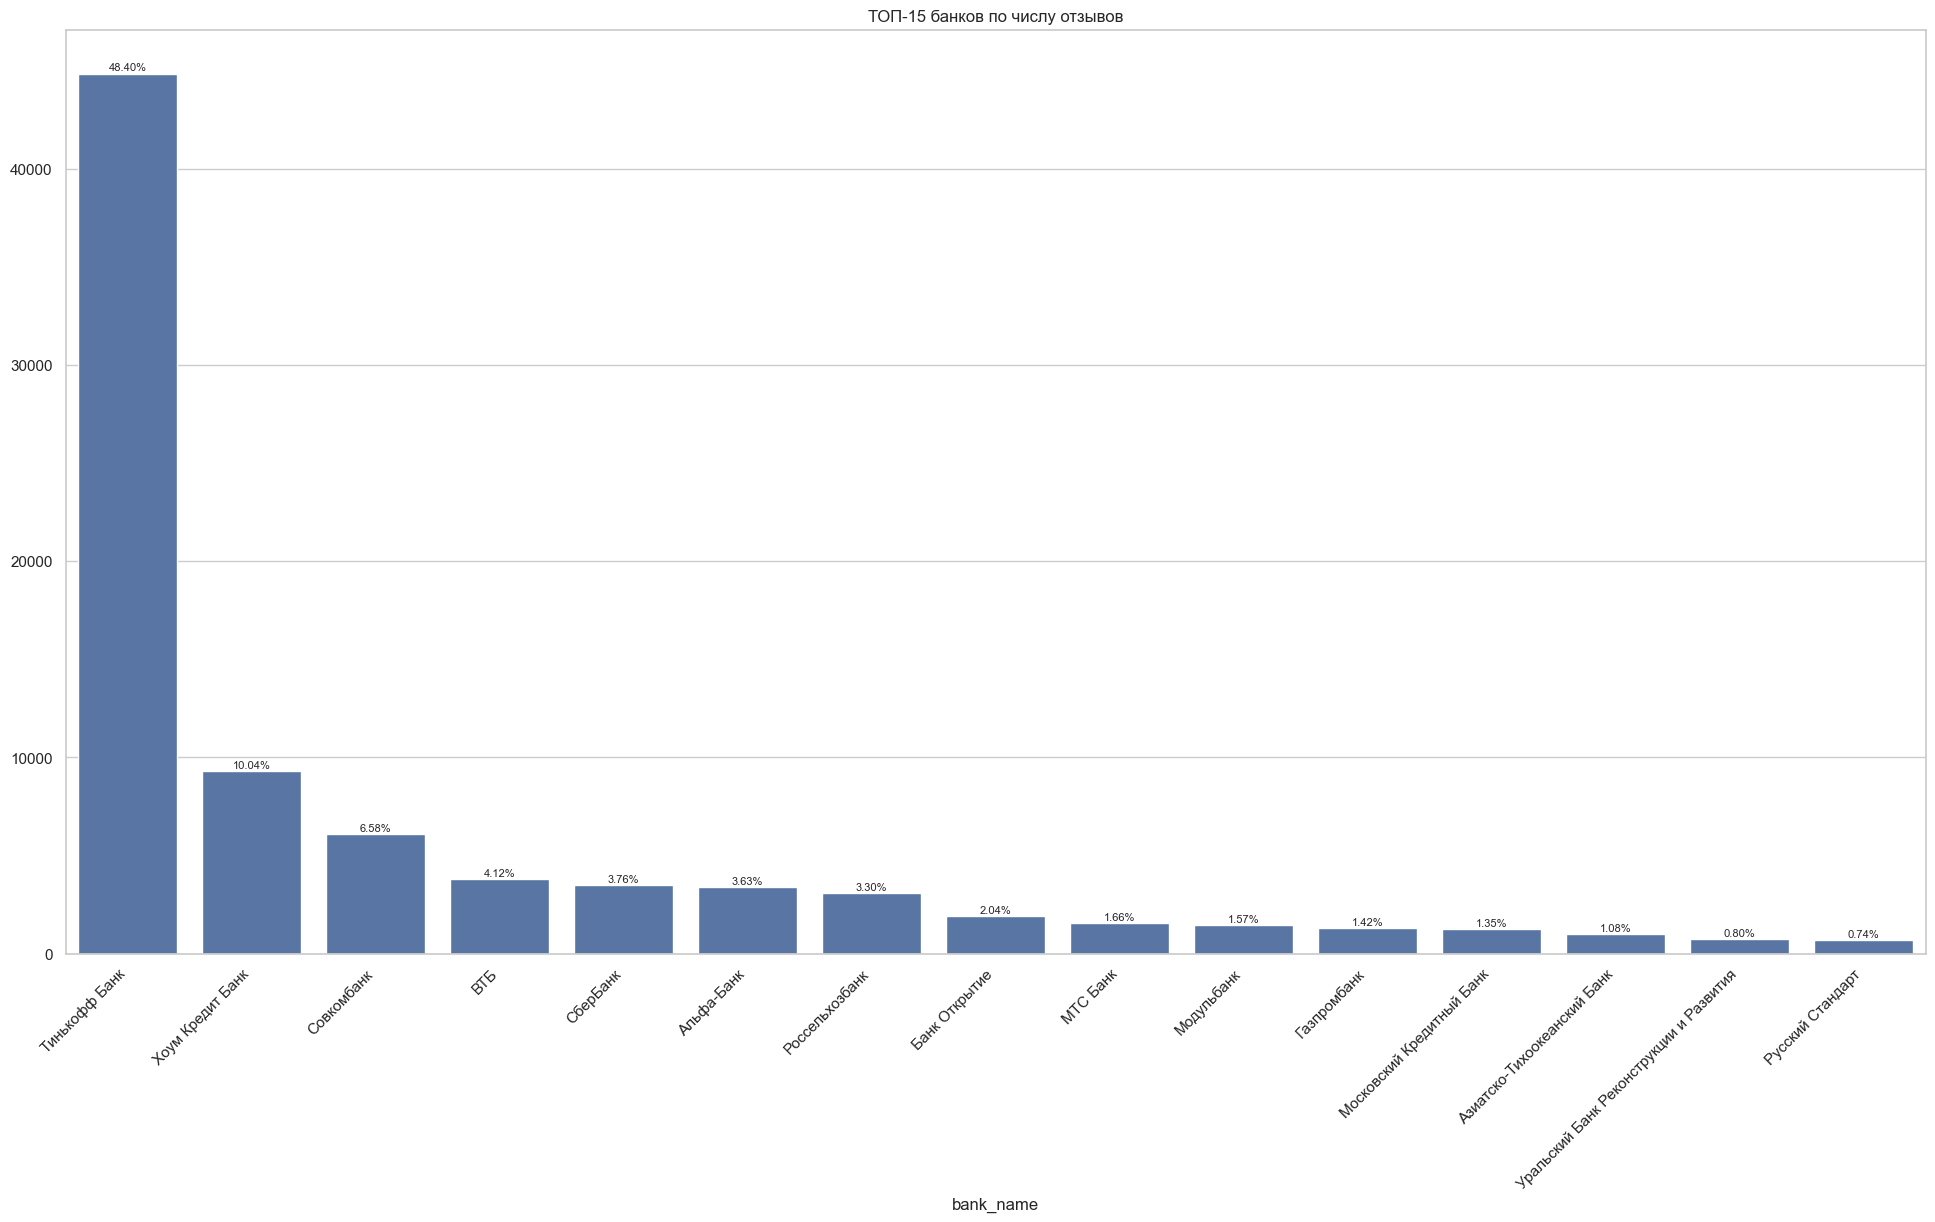

In [18]:
reviews_bank = data['bank_name'].value_counts()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(24, 12))
ax = sns.barplot(x=reviews_bank.head(15).index, y=reviews_bank.head(15).values)

plt.xticks(rotation=45, ha='right')
plt.title('ТОП-15 банков по числу отзывов')

total_reviews = len(data['bank_name'])
for i, value in enumerate(reviews_bank.head(15).values):
    percentage = (value / total_reviews) * 100
    ax.text(i, value + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()


**Исходя из представленной столбчатой диаграммы, хочу сразу выделить необыкновенно большое количество отзывов о Тинькофф Банке - 48.4%. На мой взгляд, это немного странно поскольку он имеет уж слишком большой отрыв от остальных.**

- **Необходимо проверить на дисбаланс в данных (неравномерное распределение между классами целевой переменной: положительные, отрицательные отзывы)**
- Возможно придется использовать `undersampling`, `кросс-валидацию с учетом стратификации`

#### `1.2.2` Банк с самым высоким средним рейтингом из топ-15 <a class="anchor" id="02.2.2"></a>

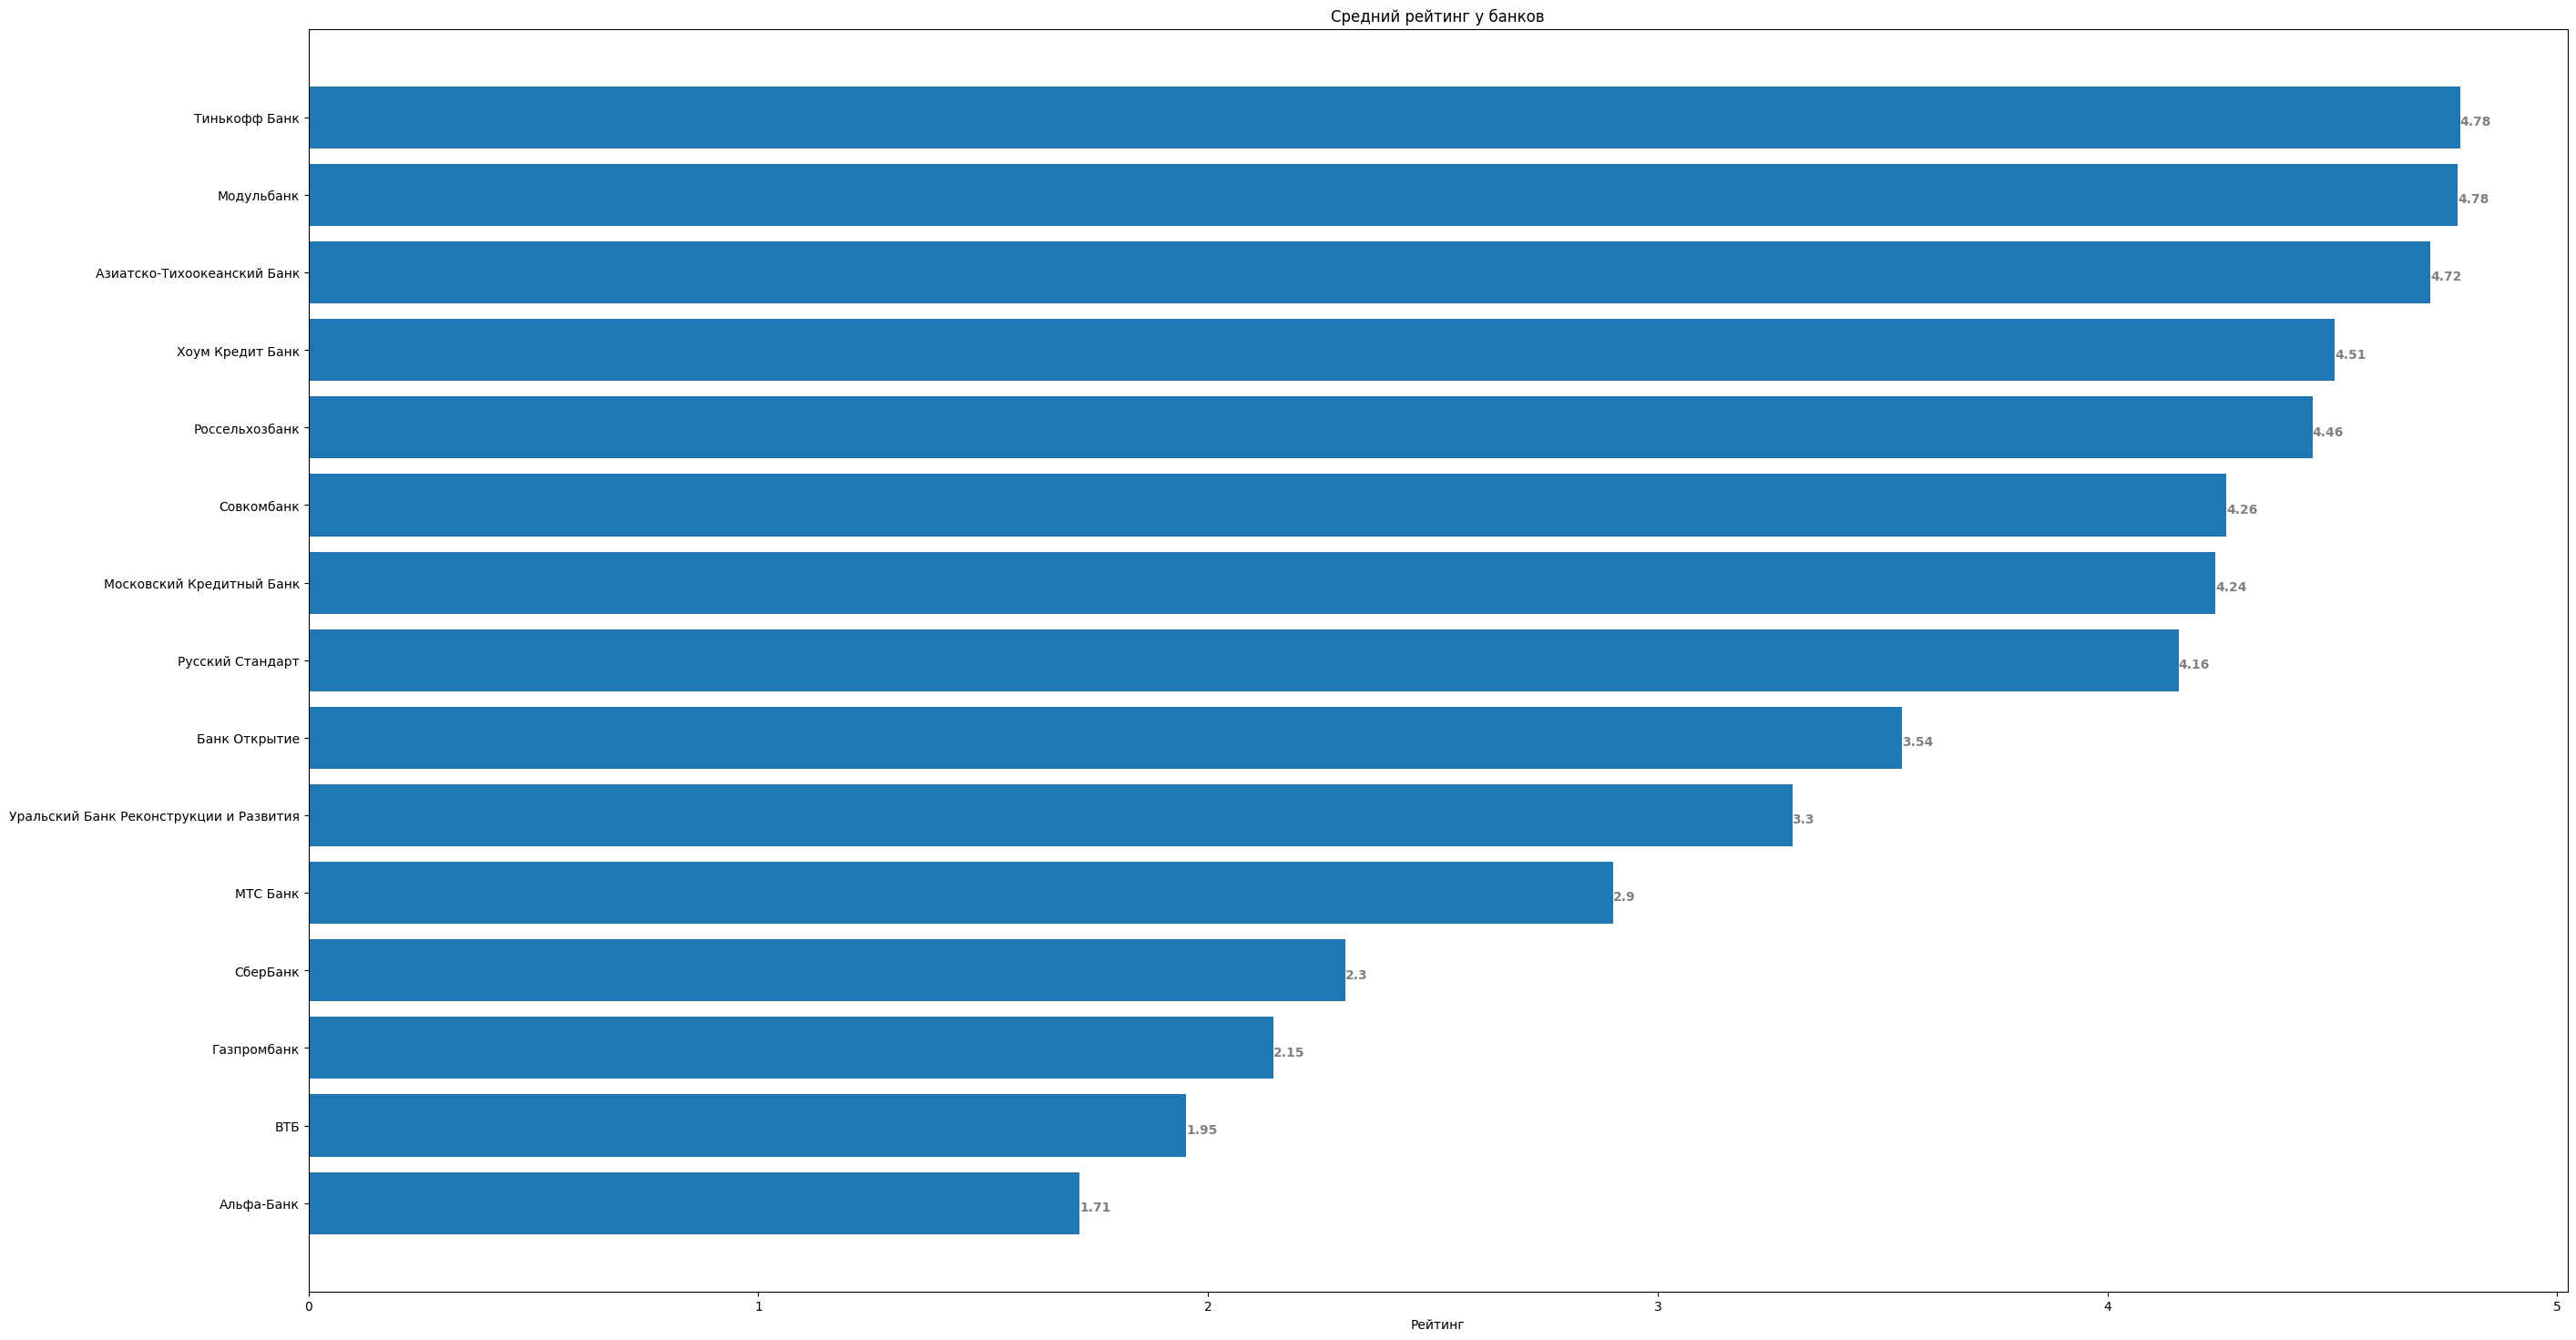

In [19]:
reviews_per_bank = data['bank_name'].value_counts()
reviews_per_bank_df = pd.DataFrame({'bank_name': reviews_per_bank.index, 'review_count': reviews_per_bank.values})

top_banks = reviews_per_bank_df.head(15)

top_banks = top_banks.copy()

# Вычисляем средний рейтинг для каждого банка
top_banks.loc[:, 'mean_rating'] = top_banks['bank_name'].apply(
    lambda bank_name: data[data['bank_name'] == bank_name]['rating'].mean()).values

# Сортируем по среднему рейтингу
top_banks.sort_values(by='mean_rating', ascending=False, inplace=True)

# Отображение
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(32, 18))

people = top_banks['bank_name']
y_pos = np.arange(len(top_banks['bank_name']))
performance = top_banks['mean_rating']

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width(), i.get_y() + 0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

ax.set_xlabel('Рейтинг')
ax.set_title('Средний рейтинг у банков')

plt.show()

**На первый взгляд, `Тинькофф банк` и `Модульбанк` делят первое место по рейтингу из топ-15**

- **Чтобы убедиться в этом, посчитаем средний рейтинг с точностью до 6-ти знаков после запятой**

In [20]:
reviews_per_bank = data['bank_name'].value_counts()
reviews_per_bank_df = pd.DataFrame({'bank_name': reviews_per_bank.index, 'review_count': reviews_per_bank.values})

top_banks = reviews_per_bank_df.head(15)

top_banks = top_banks.copy()

top_banks.loc[:, 'mean_rating'] = top_banks['bank_name'].apply(
    lambda bank_name: data[data['bank_name'] == bank_name]['rating'].mean())

top_banks.sort_values(by='mean_rating', ascending=False, inplace=True)

print(top_banks[['bank_name', 'mean_rating']])

                                  bank_name  mean_rating
0                             Тинькофф Банк     4.783622
9                                Модульбанк     4.778926
12              Азиатско-Тихоокеанский Банк     4.718000
1                          Хоум Кредит Банк     4.505645
6                            Россельхозбанк     4.455585
2                                Совкомбанк     4.264098
11                Московский Кредитный Банк     4.240192
14                         Русский Стандарт     4.158200
7                             Банк Открытие     3.543295
13  Уральский Банк Реконструкции и Развития     3.298928
8                                  МТС Банк     2.901427
4                                  СберБанк     2.304847
10                              Газпромбанк     2.145358
3                                       ВТБ     1.950970
5                                Альфа-Банк     1.714371


In [21]:
rating_1 = top_banks.iloc[0]['mean_rating']  # Средний рейтинг банка на первом месте
rating_2 = top_banks.iloc[1]['mean_rating']  # Средний рейтинг банка на втором месте

percentage_superiority = ((rating_1 - rating_2) / abs(rating_2)) * 100

print(f"Процентное превосходство {Fore.YELLOW}{top_banks.iloc[0]['bank_name']}{Style.RESET_ALL} над {Fore.YELLOW}{top_banks.iloc[1]['bank_name']}{Style.RESET_ALL}: {Fore.GREEN}{percentage_superiority:.6f}%{Style.RESET_ALL}")

Процентное превосходство Тинькофф Банк над Модульбанк: 0.098266%


**Как можно заметить, Тинькофф все-таки превосходит по рейтингу отзывов своего конкурента в лице `Модульбанка`. Разница, составляет 0.004696 ≈ `0.098266%`**

#### `1.2.3` Вывод об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов <a class="anchor" id="02.2.3"></a>

**Рассчитаем, на какой временной промежуток (в месяцах) распространяются представленные в данных сведения** 

In [22]:
min_date = data['date'].min()
max_date = data['date'].max()

min_date_period = min_date.to_period('M')
max_date_period = max_date.to_period('M')
duration_in_months = (max_date_period - min_date_period).n + 1

min_date_year = min_date.strftime("%d %B %Y")
max_date_year = max_date.strftime("%d %B %Y")

print(f"Данные представлены с {Fore.YELLOW}{min_date_year}{Style.RESET_ALL} по {Fore.CYAN}{max_date_year}{Style.RESET_ALL}")
print(f"\n{Fore.BLUE}Продолжительность данных:{Style.RESET_ALL} {duration_in_months:.2f} месяцев")


date_periods = pd.period_range(min_date.to_period('M'), max_date.to_period('M'), freq='M')

print(f"\n{Fore.GREEN}Месяцы в данных:{Style.RESET_ALL}")
for date_period in date_periods:
    print(f"{date_period.strftime('%B %Y')}")

Данные представлены с 02 September 2022 по 03 January 2023

Продолжительность данных: 5.00 месяцев

Месяцы в данных:
September 2022
October 2022
November 2022
December 2022
January 2023


In [44]:
def calculate_top_banks_avg_rating(data, top_banks, top_count=5):
    data = data.assign(
        month=data['date'].dt.month,
        year=data['date'].dt.year
    )

    top_banks_data = top_banks.sort_values('review_count', ascending=False).head(top_count)

    grouped_data = data.groupby(['bank_name', 'month', 'year'])['rating'].mean().reset_index()

    top_banks_data = grouped_data[grouped_data['bank_name'].isin(top_banks_data['bank_name'])]

    result_data = pd.pivot_table(top_banks_data, values='rating', index=['month', 'year'], columns='bank_name').reset_index()

    result_data = result_data[::-1]
    result_data.reset_index(drop=True)

    return result_data

bank_name,month,year,ВТБ,СберБанк,Совкомбанк,Тинькофф Банк,Хоум Кредит Банк
0,12,2022,1.898223,1.870871,4.524412,4.650367,4.626565
1,11,2022,1.993778,2.562708,4.230511,4.841598,4.001401
2,10,2022,1.914620,2.777547,3.846561,4.865863,3.591479
3,9,2022,2.073814,1.920000,3.882129,3.888102,4.058275
4,1,2023,1.148148,1.400000,4.419355,3.990291,2.833333


In [45]:
result_data = calculate_top_banks_avg_rating(data, top_banks)

result_data.index += 1

result_data

bank_name,month,year,ВТБ,СберБанк,Совкомбанк,Тинькофф Банк,Хоум Кредит Банк
5,12,2022,1.898223,1.870871,4.524412,4.650367,4.626565
4,11,2022,1.993778,2.562708,4.230511,4.841598,4.001401
3,10,2022,1.914620,2.777547,3.846561,4.865863,3.591479
2,9,2022,2.073814,1.920000,3.882129,3.888102,4.058275
1,1,2023,1.148148,1.400000,4.419355,3.990291,2.833333


In [46]:
result_data.describe()

bank_name,month,year,ВТБ,СберБанк,Совкомбанк,Тинькофф Банк,Хоум Кредит Банк
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.600000,2022.200000,1.805716,2.106225,4.180593,4.447244,3.822211
std,4.393177,0.447214,0.374185,0.558542,0.307558,0.472615,0.664443
min,1.000000,2022.000000,1.148148,1.400000,3.846561,3.888102,2.833333
25%,9.000000,2022.000000,1.898223,1.870871,3.882129,3.990291,3.591479
50%,10.000000,2022.000000,1.914620,1.920000,4.230511,4.650367,4.001401
75%,11.000000,2022.000000,1.993778,2.562708,4.419355,4.841598,4.058275
max,12.000000,2023.000000,2.073814,2.777547,4.524412,4.865863,4.626565


**Визуализируем**

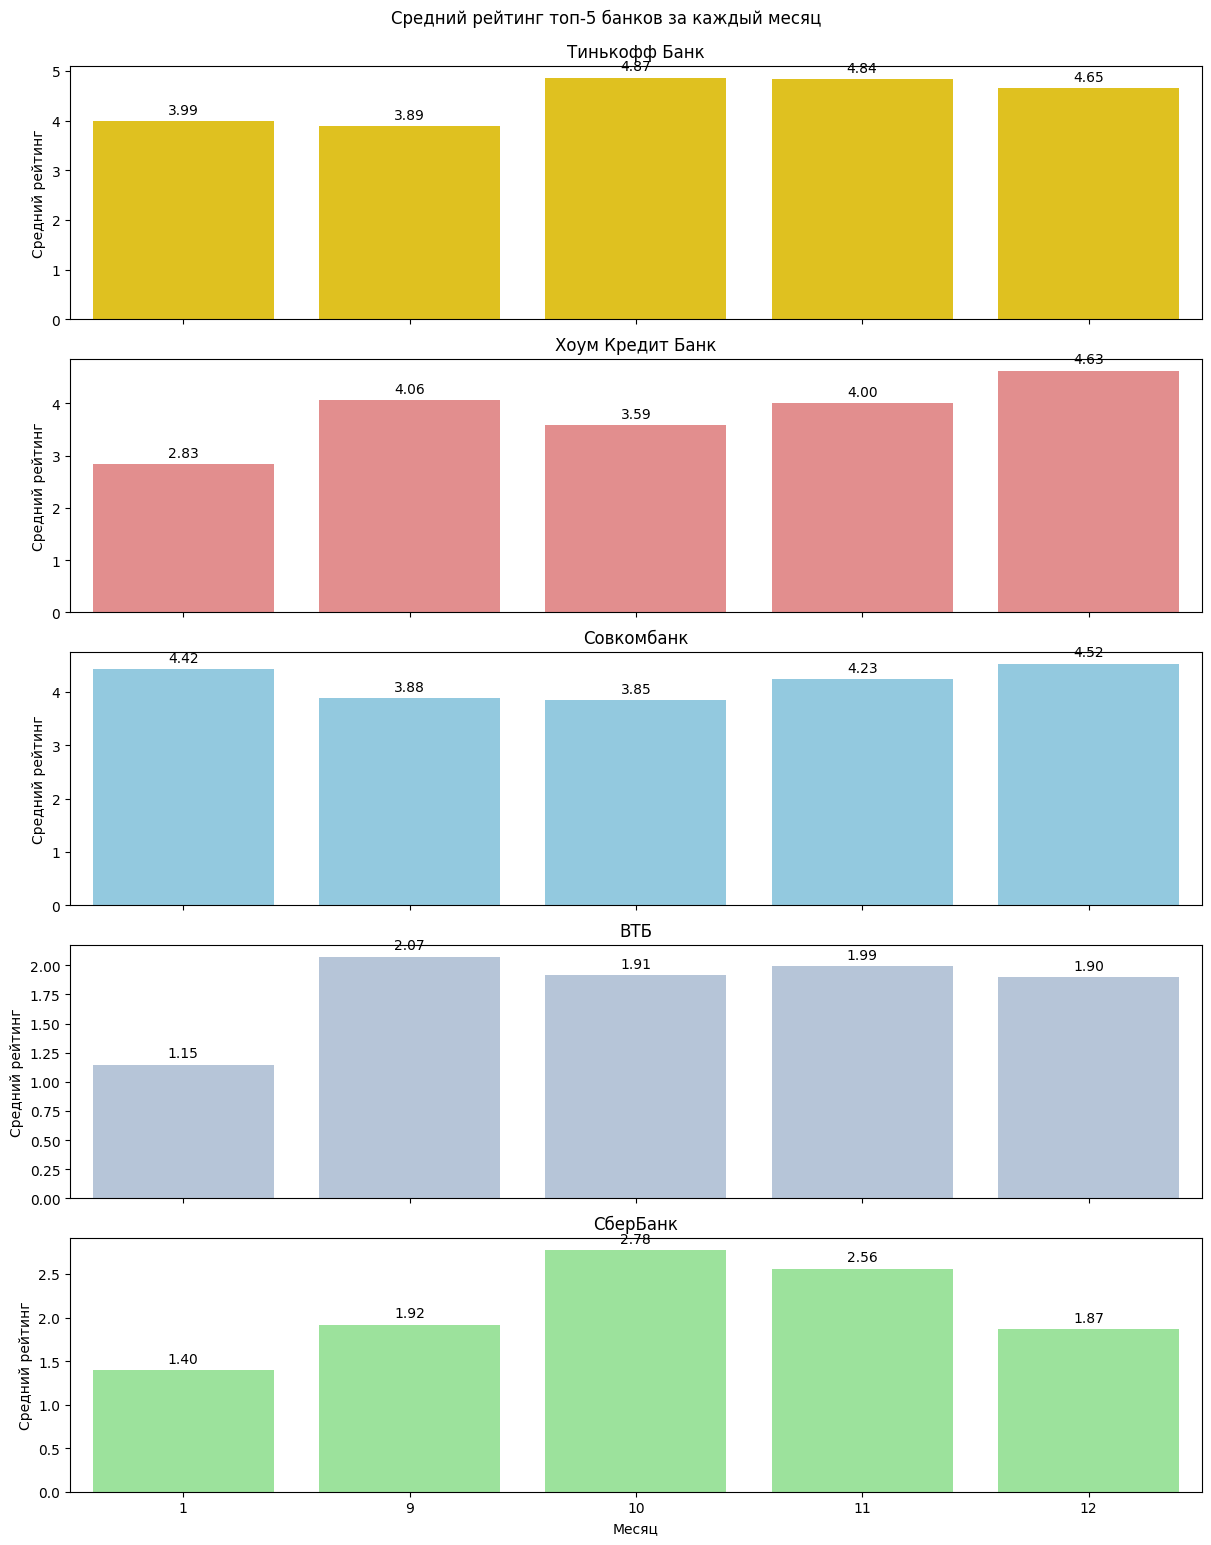

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True, constrained_layout=True)

colors = ['gold', 'lightcoral', 'skyblue', 'lightsteelblue', 'lightgreen']

for i, (bank_name, color) in enumerate(zip(top_banks['bank_name'].head(5), colors)):
    sns.barplot(data=result_data, x='month', y=bank_name, ax=axes[i], color=color)
    
    for bar in axes[i].patches:
        axes[i].annotate(format(bar.get_height(), '.2f'),
                         (bar.get_x() + bar.get_width() / 2,
                          bar.get_height()), ha='center', va='center',
                         size=10, xytext=(0, 8),
                         textcoords='offset points')
    
    axes[i].set_title(bank_name)
    axes[i].set_ylabel('Средний рейтинг')

plt.suptitle('Средний рейтинг топ-5 банков за каждый месяц', y=1.02)
plt.xlabel('Месяц')

plt.show()

**На основе представленной информации, я могу сделать вывод, что:**
1. У **Тинькофф банка**, начиная с сентября, за 5 месяцев были определенные положительные результаты, которые способствовали удовлетворенности клиентов, но к сожалению, к январю рейтинг банка снизился и почти вернулся к исходной точке. Возможно компании стоит пересмотреть операционные процессы и сконцентрироваться на потребностях конечного пользователя, чтобы вновь повышать рейтинг.
2. Насчет ситуации **Хоум Кредит банка**, здесь все довольно проблематично, поскольку резкое падение рейтинга (почти в два раза - **с 4.63 до 2.83**) за один месяц (с декабря по январь) говорит также о возможной "неправильной" операционной деятельности компании, стоит глубже проанализировать и выявить основные проблемы, с которыми сталкиваются конечные пользователи.
3. Единственная, на мой взгляд, более менее положительная и стабильная ситуация у **Совкомбанка**. Да, безусловно, есть некоторые моменты (рейтинг банка снизился на `0.1` с декабря по январь), но все же, я считаю, что у него неплохой рост рейтинга, по крайней мере лучший из топ-5.
4. У **ВТБ** все достаточно плохо, поскольку рейтинг банка неумолимо падал вниз, если сравнивать показатели с сентября по январь, можно зафиксировать падение почти в 2 раза.
5. **Сбербанк** в начале показывал положительную динамику, но, к сожалению, к январю рейтинг банка снизился ниже исходной точки на `0.52`.

### Дополнительный EDA

#### `1.3.1` Проверка на дисбаланс (неравномерное распределение между классами целевой переменной: положительные, отрицательные отзывы)

#### `1.3.2` Проверка на сезонные тенденции

#### `1.3.3` Корреляция между длиной отзыва и оценкой**

**Перед тем как преступим к проверки корреляционного отношения, нужно проверить данные на соответствие нормальному закону распределения**

- Выполнять такую проверку нужно обязательно, так как только для нормально распределенных данных мы можем в дальнейшем использовать общепринятые статистические процедуры анализа

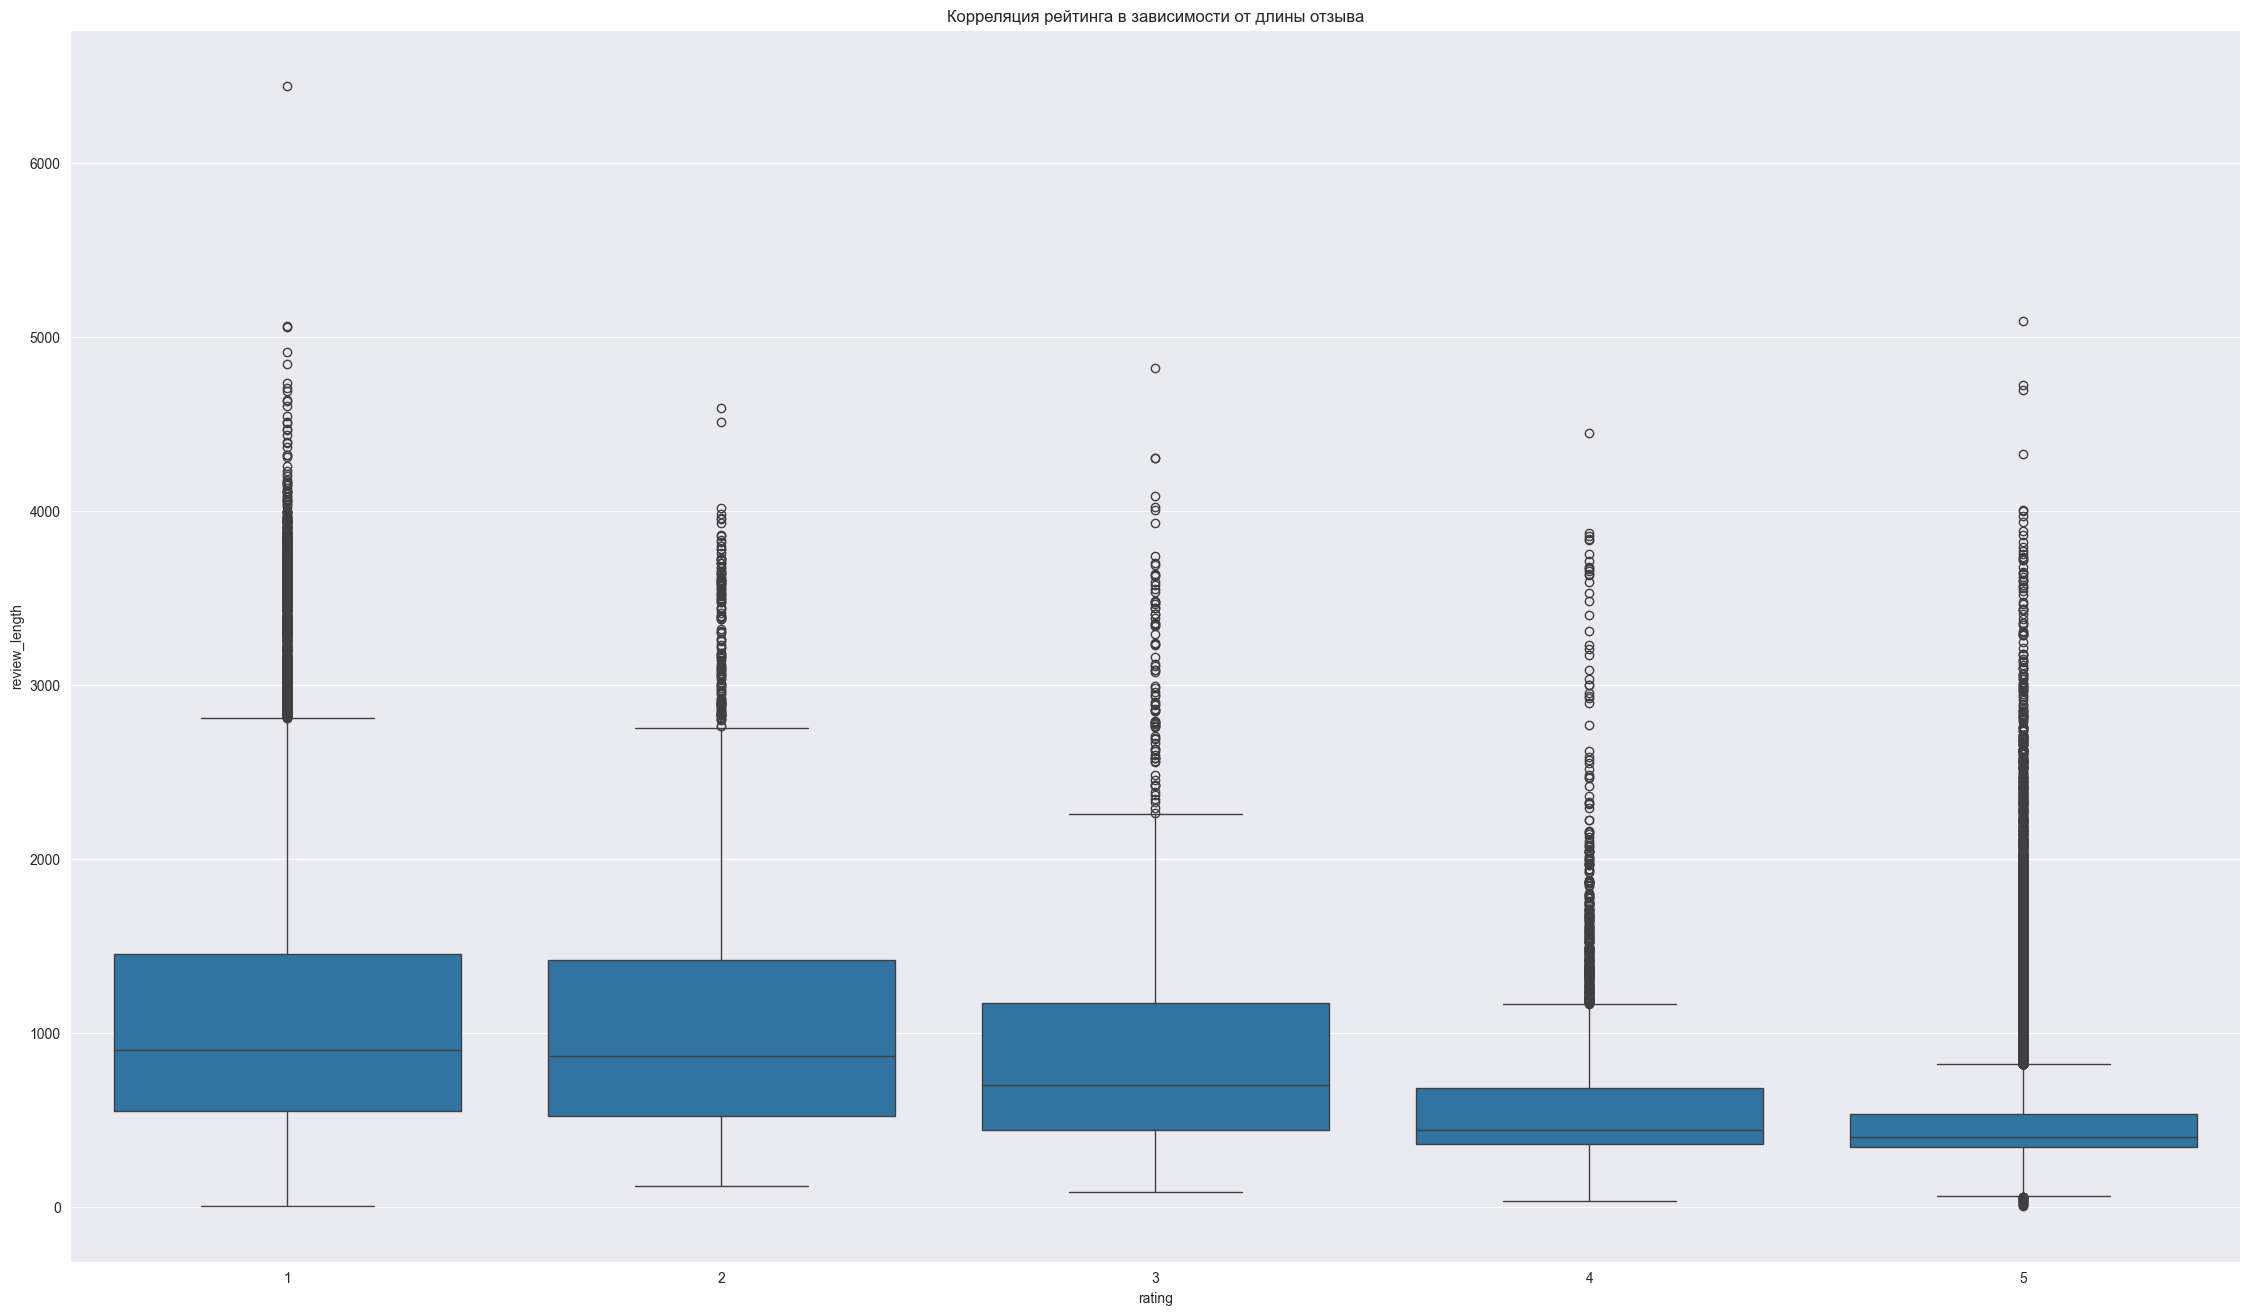

In [38]:
correlation_data = data[['rating', 'body']].copy()

correlation_data['review_length'] = correlation_data['body'].apply(len)

correlation_coefficient = correlation_data['review_length'].corr(correlation_data['rating'])

plt.figure(figsize=(28, 16))
sns.boxplot(x='rating', y='review_length', data=correlation_data)
plt.title('Корреляция рейтинга в зависимости от длины отзыва')
plt.show()



#### `1.3.4` Тематическое моделирование с применением LDA

In [ ]:
import nltk
nltk.download('punkt')

In [32]:
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

stop_words = set(stopwords.words('russian'))
texts = data['body']
texts_token = texts.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha() and word not in stop_words])

dictionary = corpora.Dictionary(texts_token)
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

**При помощи LDA алгоритма, были выделены несколько основных тематик отзывов:**
- **Тема 1 ->** связана с упоминанием банковских карт, денег, банка и других схожих слов (относиться к опыту использования банковских карт).
- **Тема 2 ->** представляет собой кластер слов, связанных с договорами, комиссией, задолжностям, погашениям и тд. (относиться к финансовым сделкам).
- **Тема 3 ->** Стоит отметить, что я нашел некоторую связь между словами благодарности (которые отражают положительную семантику) и словами "бесплатно", "кэшбек" и "быстрый". Вероятно клиенты выражают благодарность в контексте бесплатных услуг, кэшбека и быстрого обслуживания :D

## 2. Модель бинарной классификации отзывов <a class="anchor" id="02"></a>

### Инициализация ClearML для треккинга экспериментов

### Подготовка данных

#### Лемматизация текста

### С применением Logistic Regression

### На PyTorch с применением RNN LSTM

# Вывод